In [4]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  5 12:53:49 2021

@author: Andrey.Bezrukov
"""

import time
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.cluster import DBSCAN
import numpy as np

##################################################
####### define  functions 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


def Create_WaterSorption_isotherm(Sorption):
    if True:
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)
        
        for start,  end in zip(args, args[1:]):
            print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()
            
            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]
            
            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
    return isotherm_RHtarget_ads, [i for i in isotherm_adsorption], isotherm_RHtarget_des, [i for i in isotherm_desorption],  Sorption.data.time.max()- Sorption.data[split_index_ads[0]:split_index_ads[1]].time.min()


In [5]:
window1 = 50
window2 = 10
text_size = 16

result = pd.DataFrame(columns=['name','isotherm','cycleNr','kinetics'], dtype=object)

datetime_stamp = datetime.now().isoformat(timespec='seconds')

#os.mkdir(datetime_stamp+'/')

import_parameters = pd.read_csv('input_data.csv', sep=',')
import_parameters.cycleNr = import_parameters.cycleNr.astype('int32')
print(import_parameters)

                                       path_kinetics  \
0   ../../../../../data/water_sorption/DVS/kinetics/   
1   ../../../../../data/water_sorption/DVS/kinetics/   
2   ../../../../../data/water_sorption/DVS/kinetics/   
3   ../../../../../data/water_sorption/DVS/kinetics/   
4   ../../../../../data/water_sorption/DVS/kinetics/   
5   ../../../../../data/water_sorption/DVS/kinetics/   
6   ../../../../../data/water_sorption/DVS/kinetics/   
7   ../../../../../data/water_sorption/DVS/kinetics/   
8   ../../../../../data/water_sorption/DVS/kinetics/   
9   ../../../../../data/water_sorption/DVS/kinetics/   
10  ../../../../../data/water_sorption/DVS/kinetics/   
11  ../../../../../data/water_sorption/DVS/kinetics/   
12  ../../../../../data/water_sorption/DVS/kinetics/   
13  ../../../../../data/water_sorption/DVS/kinetics/   
14  ../../../../../data/water_sorption/DVS/kinetics/   
15  ../../../../../data/water_sorption/DVS/kinetics/   
16  ../../../../../data/water_sorption/DVS/kinet

path_kinetics         ../../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Syloid_kinetics_50-100um_27C_12mg-2021-07-15 1...
path_isotherm        ../../../../../data/water_sorption/DVS/isotherms/
filename_isotherm          syloid_isotherm_25C-2021-03-19 23-03-21.xls
color                                                            green
name                                                       Syloid AL-1
cycleNr                                                              3
analyze                                                              Y
to_paper                                                           NaN
Name: 0, dtype: object
File Syloid_kinetics_50-100um_27C_12mg-2021-07-15 13-38-52.xls read succesfull
File syloid_isotherm_25C-2021-03-19 23-03-21.xls read succesfull
Intersection:  [2.902772573997759, 24.161671037841884]
2.505
1.2574999999999998
0.6337499999999999
0.32187499999999997
0.4778125
0.39984374999999994
0.360859375
0.34136718749999995
0.33162109374

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:304: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


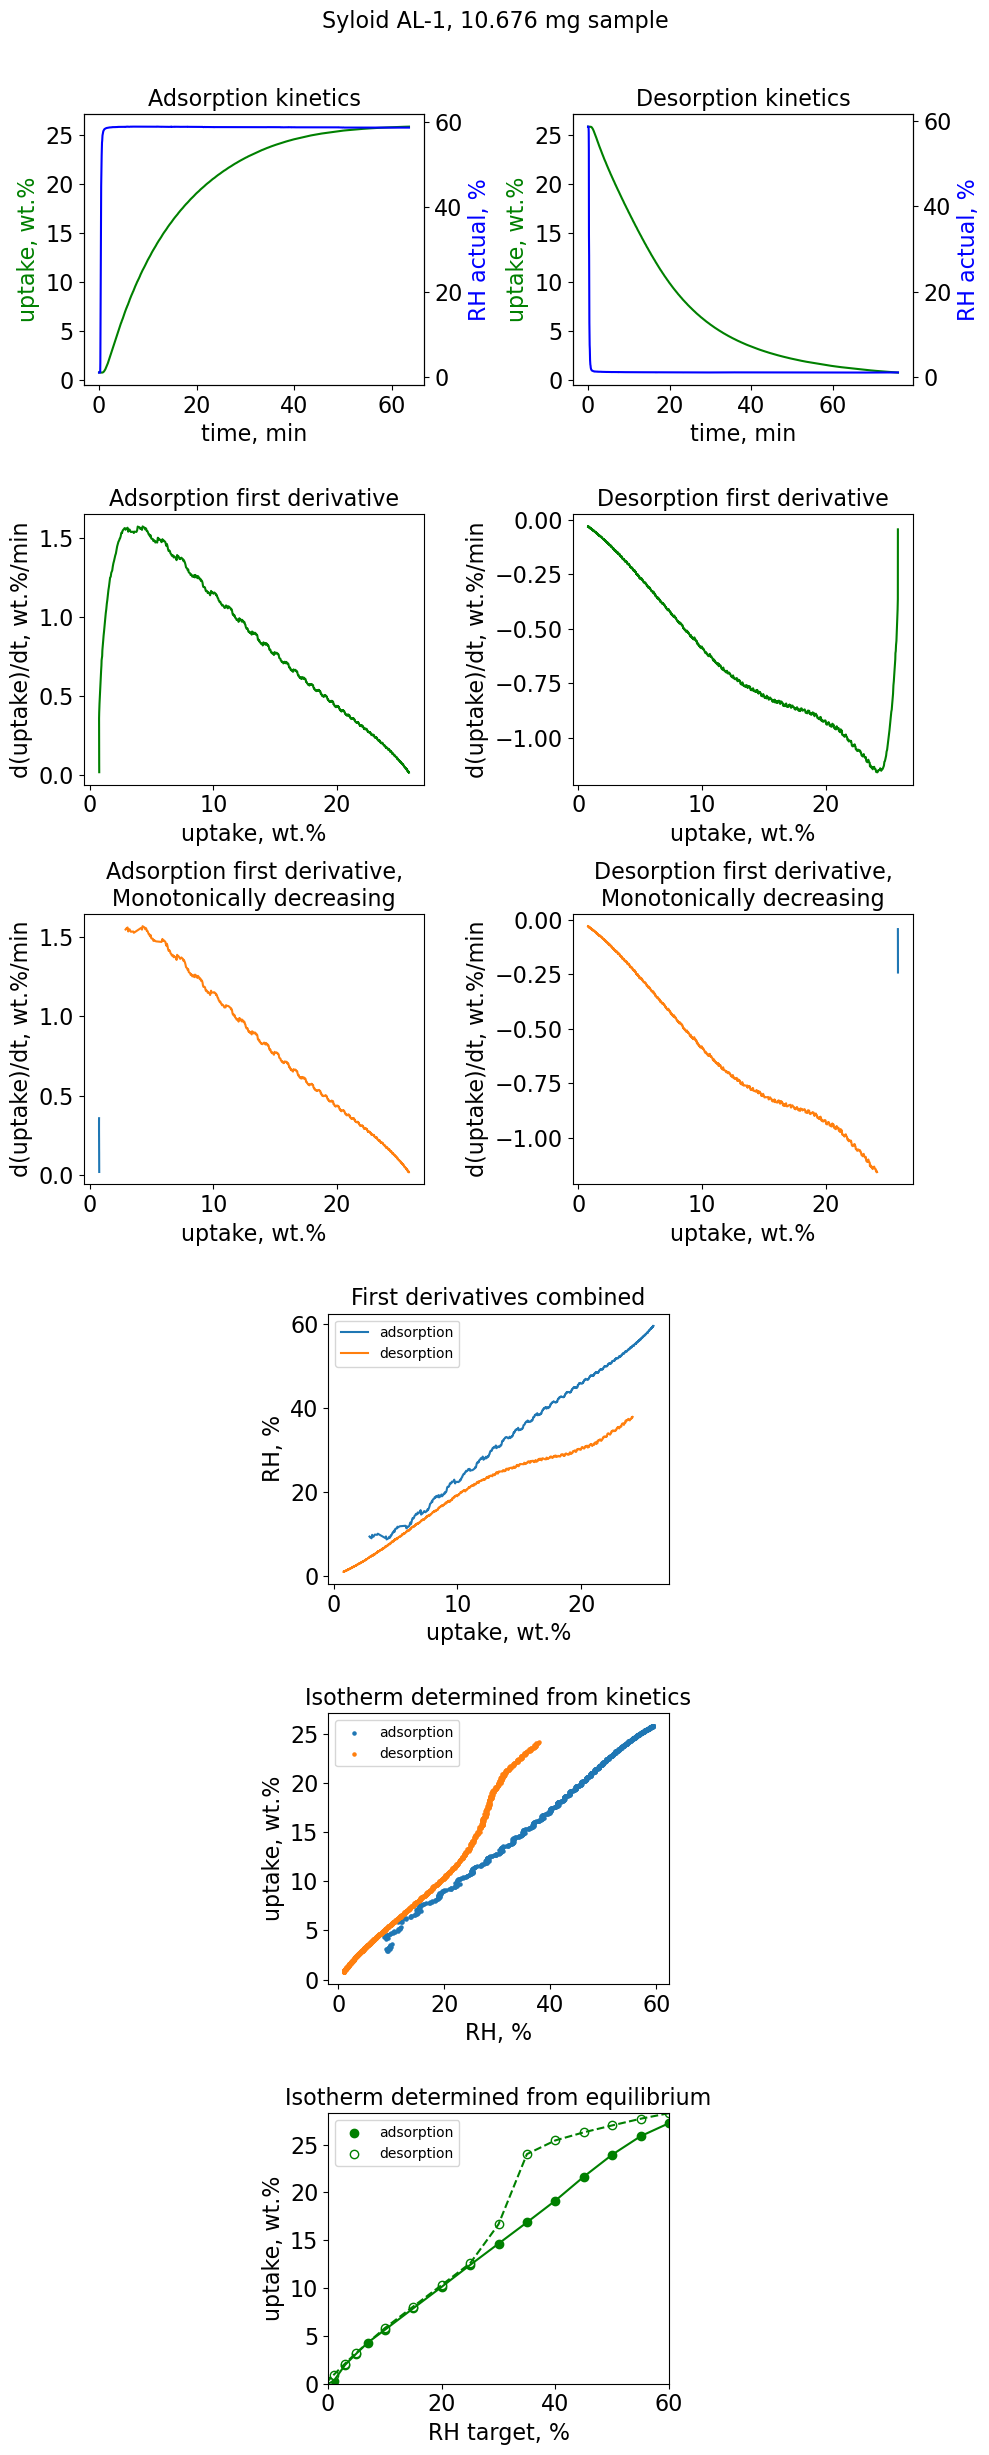

path_kinetics         ../../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Zeolite13X_TGApan_kinetics-2022-05-04 21-27-59...
path_isotherm        ../../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    20191224_Zeoleite13X - Tue 24 Dec 2019 13-41-5...
color                                                            green
name                                                       Zeolite 13X
cycleNr                                                              1
analyze                                                              Y
to_paper                                                           NaN
Name: 1, dtype: object
File Zeolite13X_TGApan_kinetics-2022-05-04 21-27-59_dmEnd.xls read succesfull
File 20191224_Zeoleite13X - Tue 24 Dec 2019 13-41-50.xlsx read succesfull
Intersection:  [2.392968961519501, 6.586739050448814]
2.505
1.2574999999999998
0.6337499999999999
0.32187499999999997
0.1659375
0.24390625
0.28289062499999995
0.3023828125
0.292636718749

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:304: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


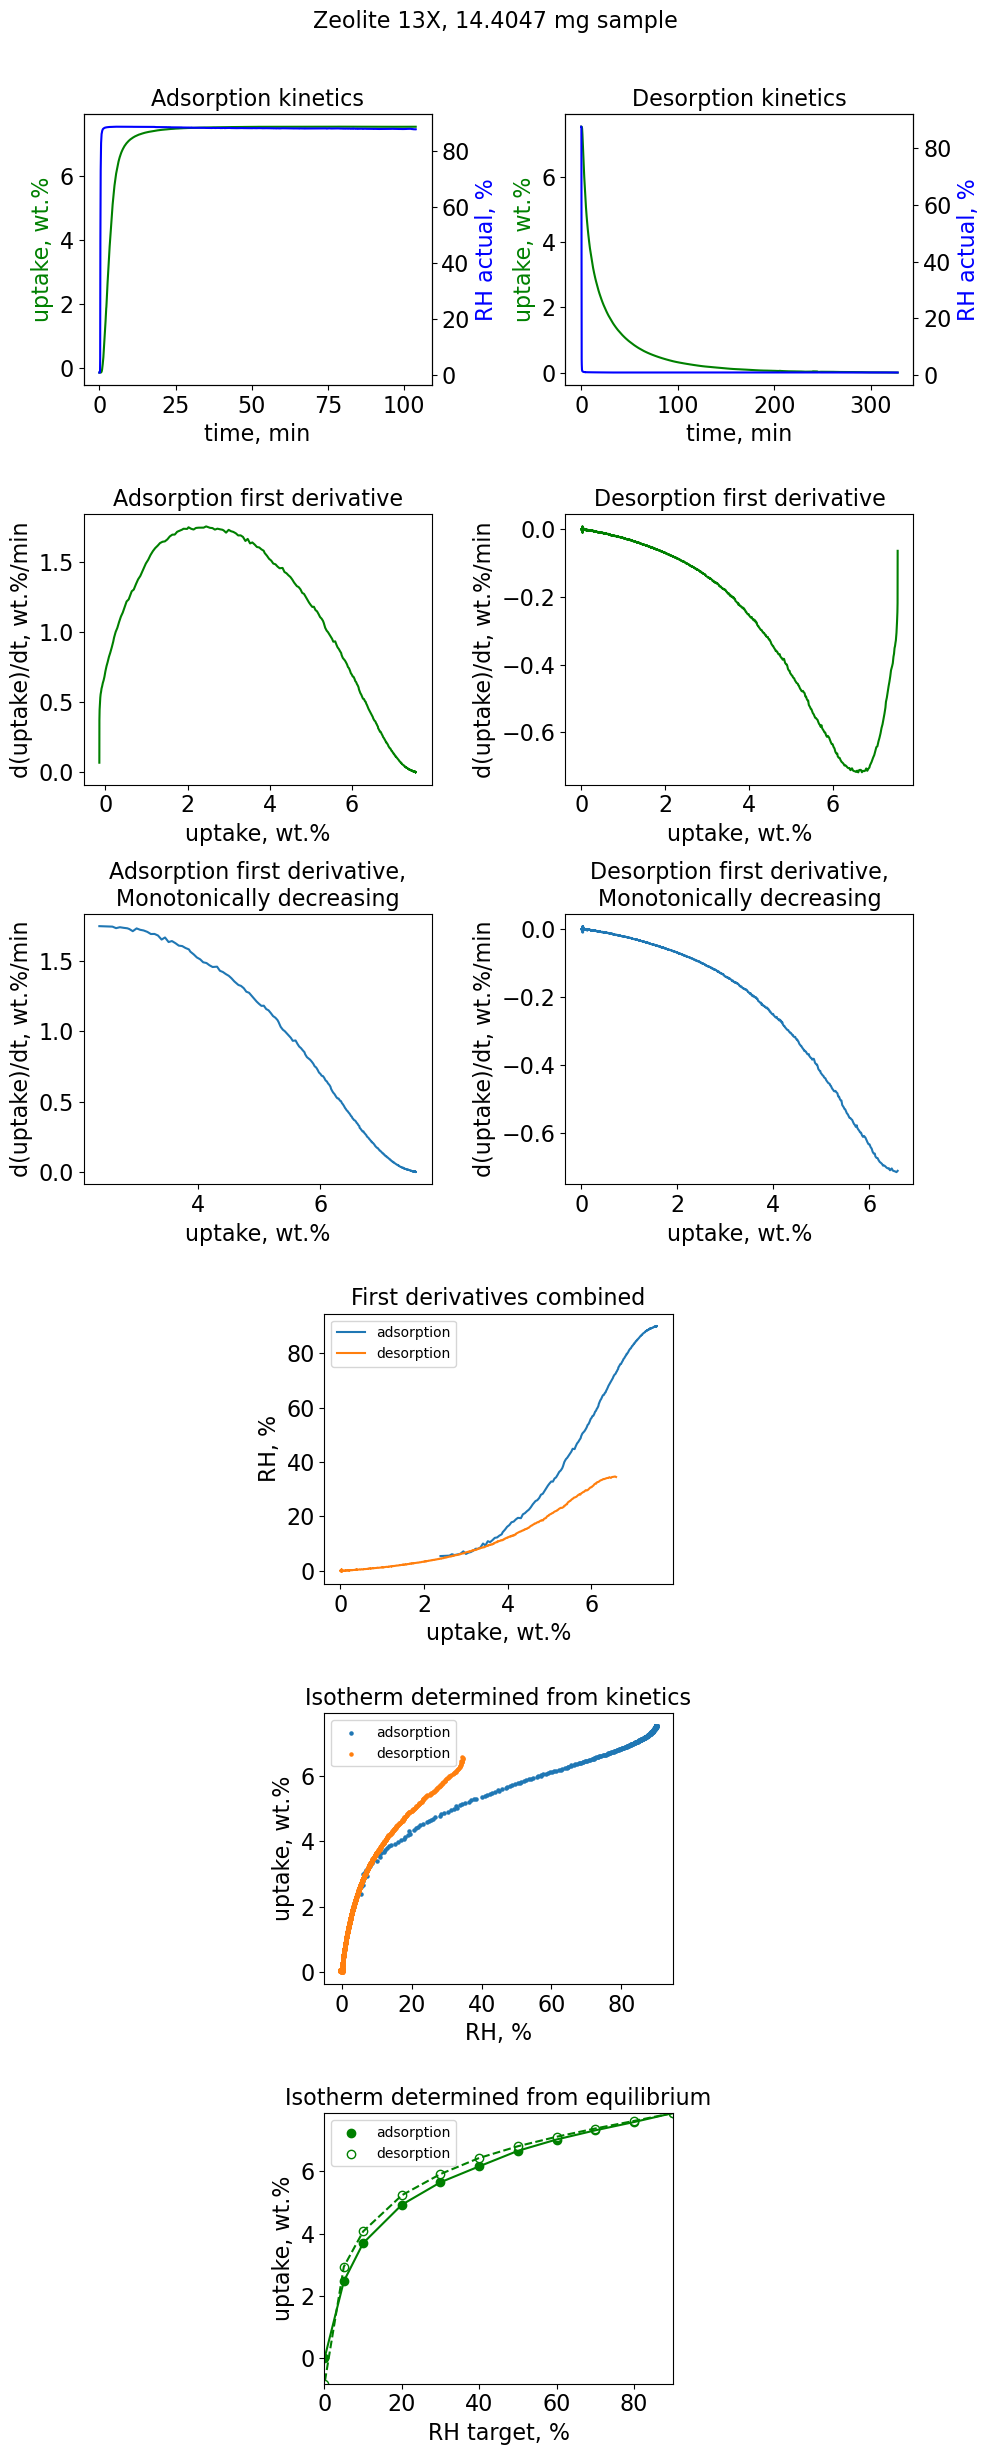

path_kinetics         ../../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    CAU-10-H_NK-1-153_kinetics_20mg_27C_50-100-202...
path_isotherm        ../../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-...
color                                                            green
name                                                          CAU-10-H
cycleNr                                                              3
analyze                                                              Y
to_paper                                                           NaN
Name: 2, dtype: object
File CAU-10-H_NK-1-153_kinetics_20mg_27C_50-100-2021-06-24 13-11-08_1.xls read succesfull
File CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx read succesfull
Intersection:  [2.0282099724032876, 25.85534970672312]
2.505
1.2574999999999998
0.6337499999999999
0.32187499999999997
0.1659375
0.24390625
0.28289062499999995
0.3023828125


C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:304: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


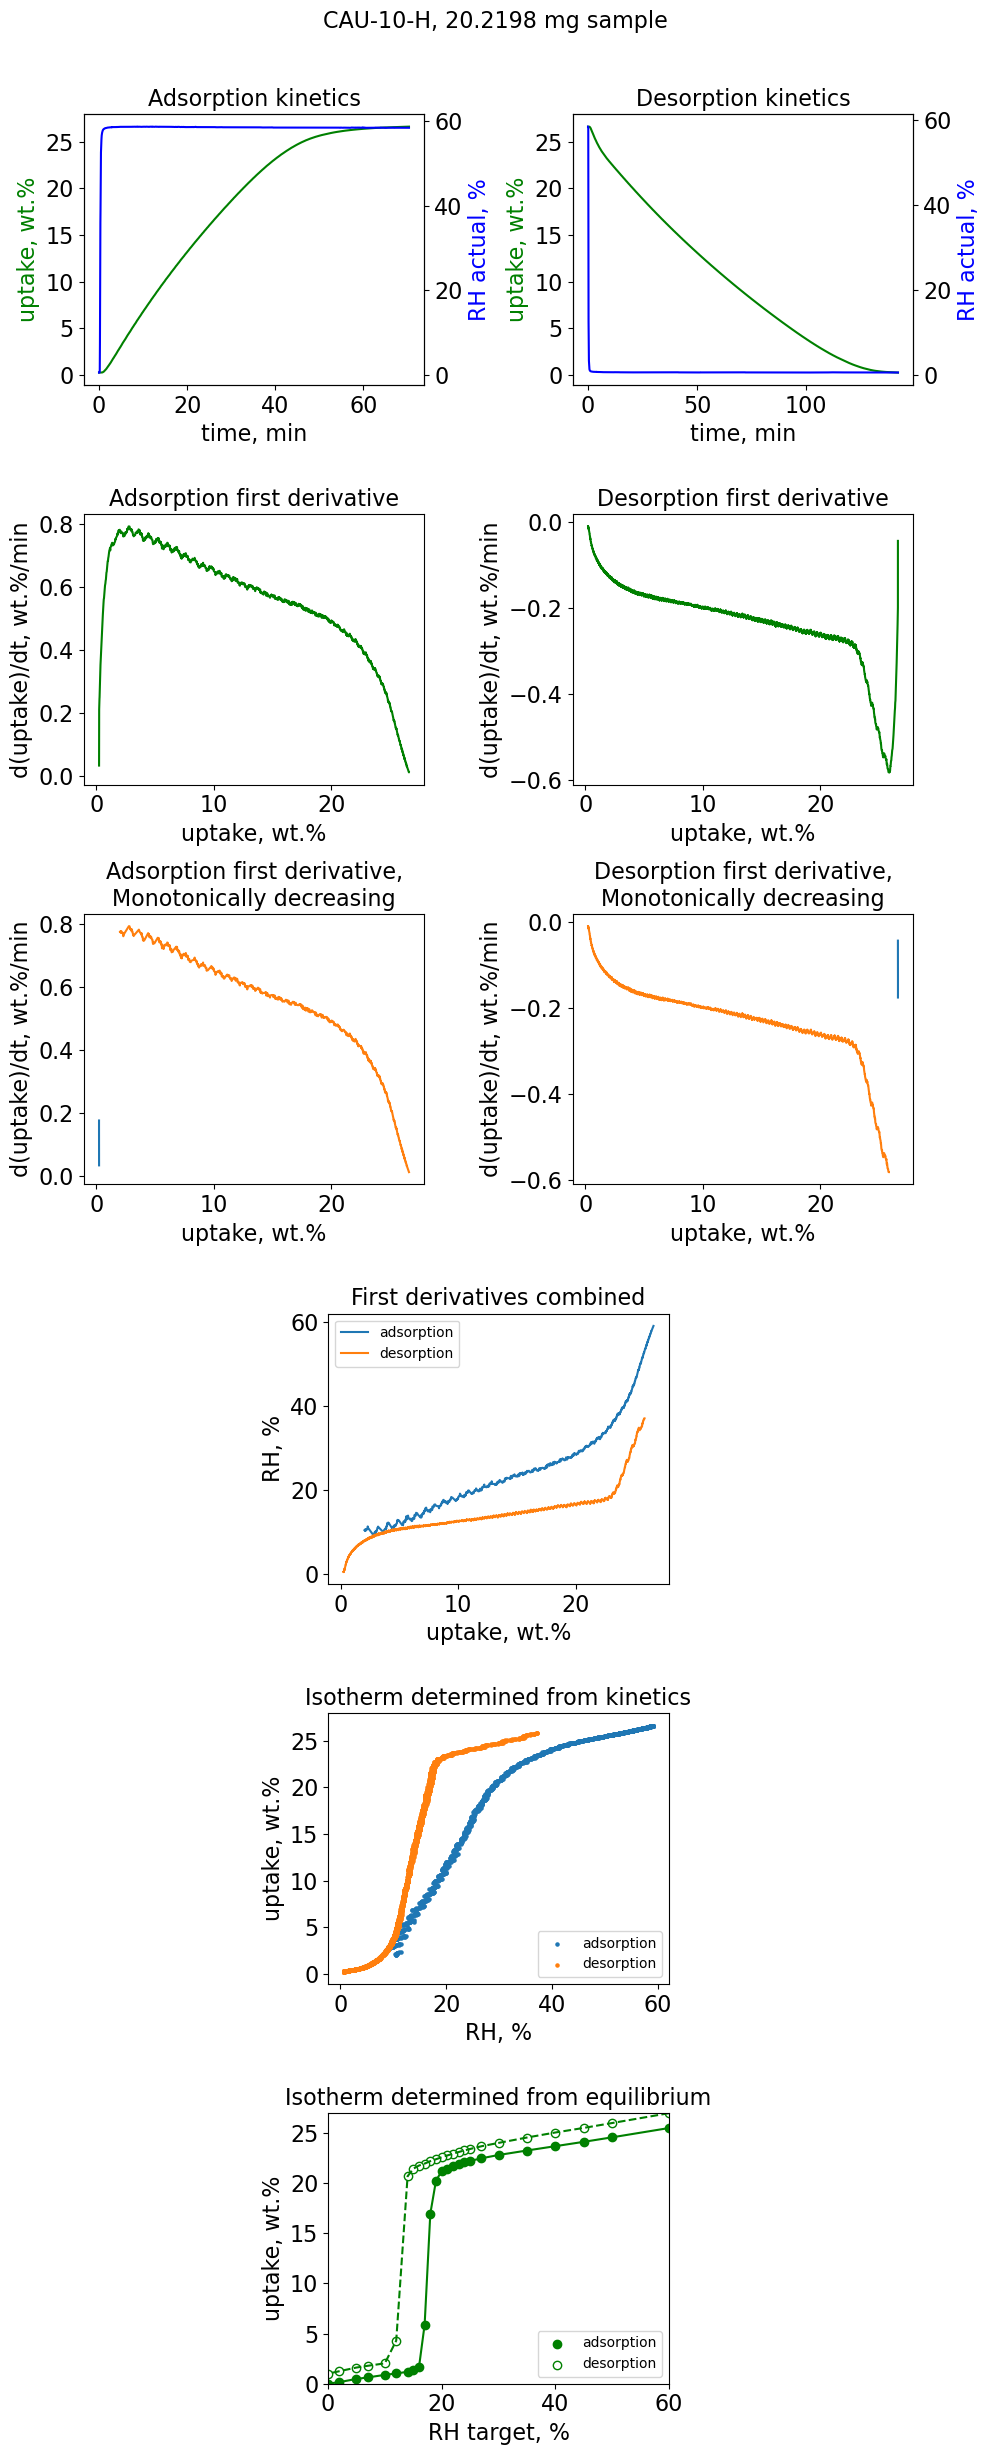

path_kinetics         ../../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    MIL-100Fe_SS-2-1232_50-100um_9mg-2022-06-11 19...
path_isotherm        ../../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    MIL-100Fe_SS-2-1232_isotherm_27C-2021-07-07 00...
color                                                            green
name                                                         MIL-100Fe
cycleNr                                                              3
analyze                                                              Y
to_paper                                                           NaN
Name: 3, dtype: object
File MIL-100Fe_SS-2-1232_50-100um_9mg-2022-06-11 19-51-35.xls read succesfull
File MIL-100Fe_SS-2-1232_isotherm_27C-2021-07-07 00-30-29.xls read succesfull
Intersection:  [5.776386604276792, 46.22386891738665]
2.505
1.2574999999999998
0.6337499999999999
0.32187499999999997
0.1659375
0.24390625
0.28289062499999995
0.3023828125
0.31212890

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:304: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


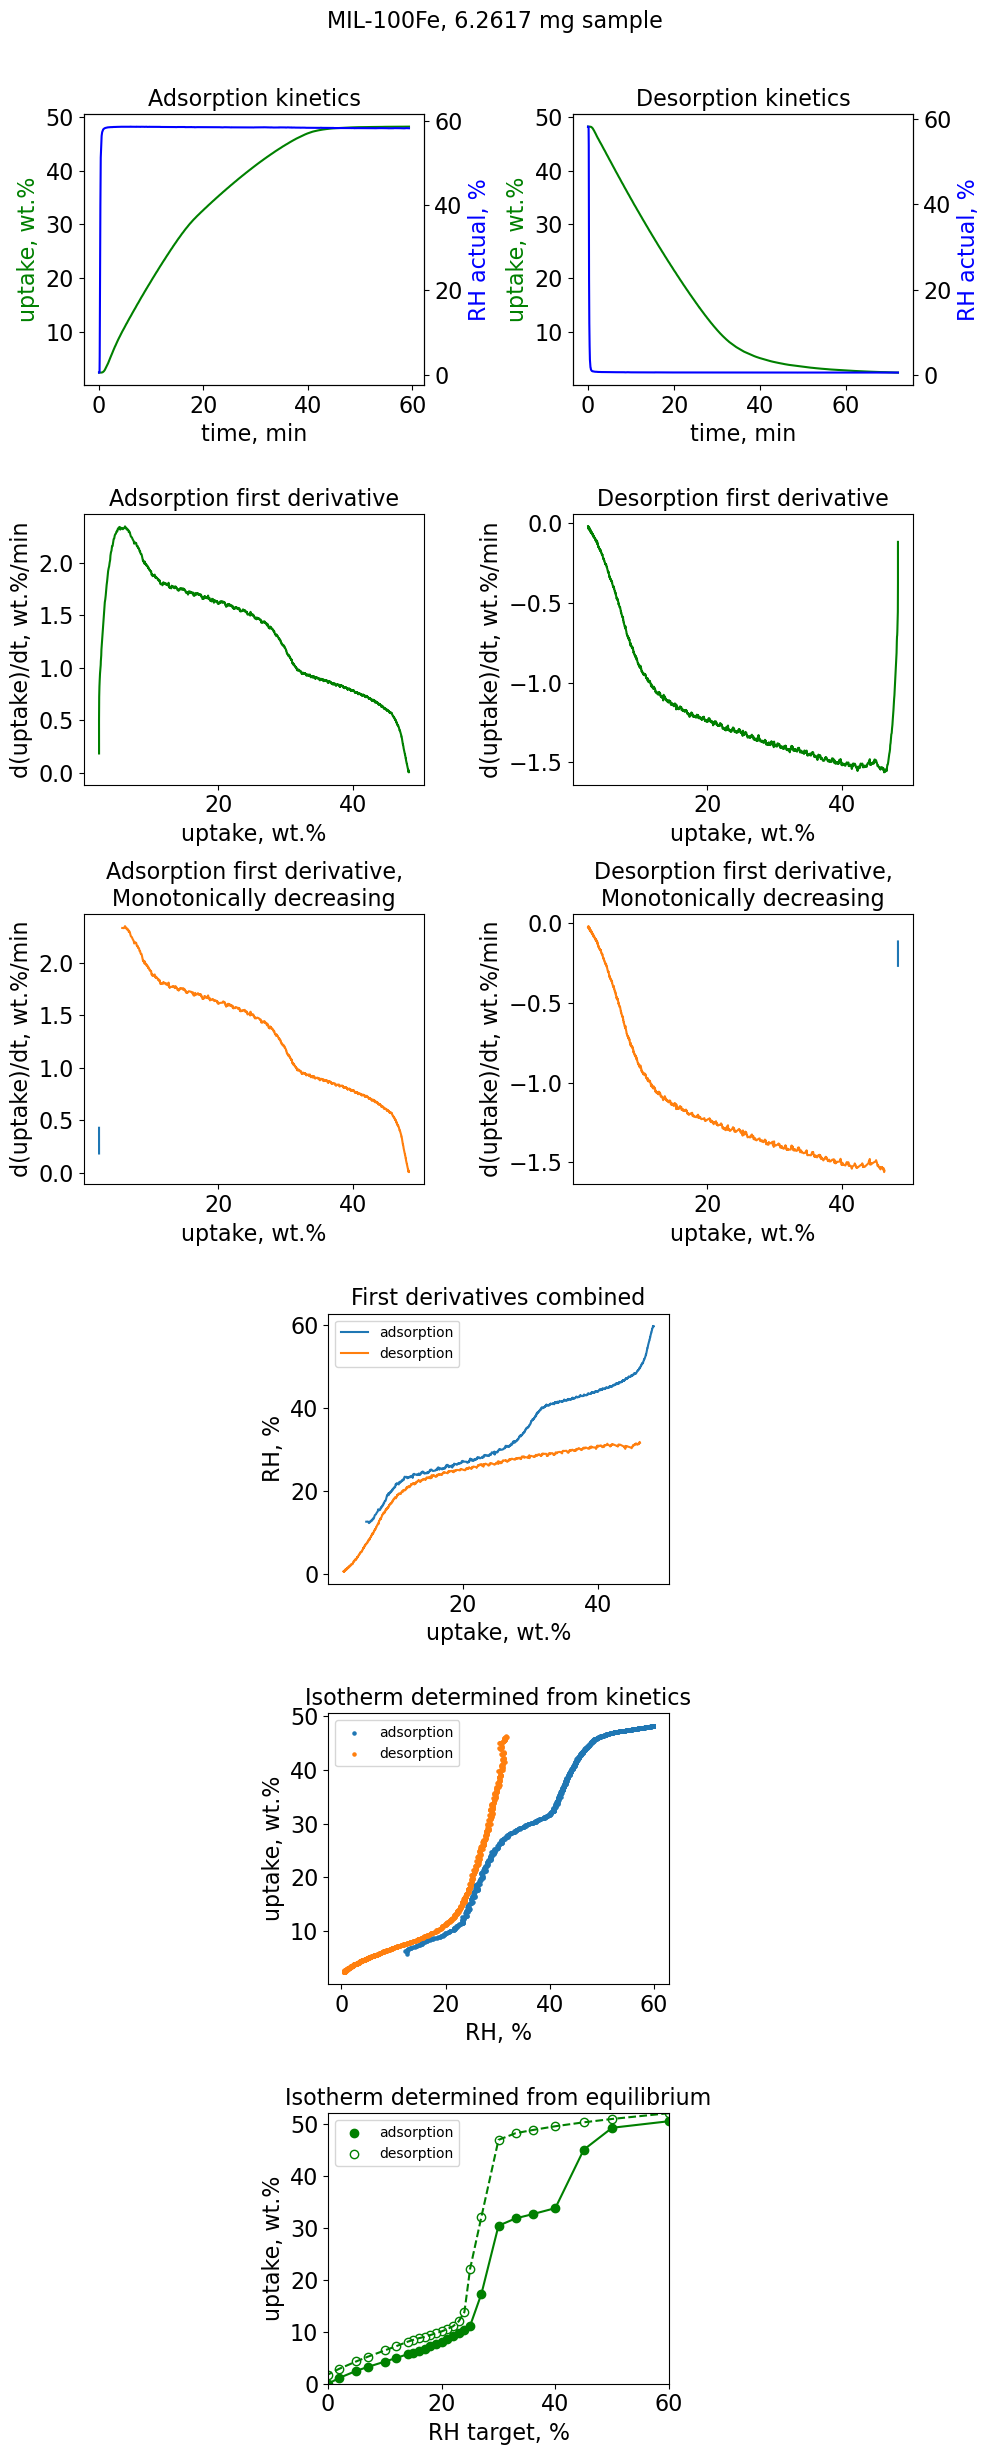

In [6]:
for indx in import_parameters[import_parameters.analyze=='Y'].index:
    print(import_parameters.iloc[indx, :])
    ## import kinetics
    Sorption_kinetics = file_Sorption()
    try:
        Sorption_kinetics.read_file(import_parameters.path_kinetics[indx],import_parameters.filename_kinetics[indx])
        if Sorption_kinetics.import_success:
            if Sorption_kinetics.fluid != 'water vapor':
                del Sorption_kinetics
                print('Wrong fluid: ',Sorption_kinetics.fluid)
        else:
            del Sorption_kinetics
            print(import_parameters.filename_kinetics[indx], 'failed')
            continue
    except Exception as e:
        print(e)
        print(import_parameters.filename_kinetics[indx], 'failed')
        continue
        
    ## import isotherm
    Sorption_isotherm = file_Sorption()
    try:
        Sorption_isotherm.read_file(import_parameters.path_isotherm[indx],import_parameters.filename_isotherm[indx])
        if Sorption_isotherm.import_success:
            if Sorption_isotherm.fluid != 'water vapor':
                del Sorption_isotherm
                print('Wrong fluid: ',Sorption_isotherm.fluid)
        else:
            del Sorption_isotherm
            print(import_parameters.filename_isotherm[indx], 'failed')
    except Exception as e:
        print(e)
        print(import_parameters.filename_isotherm[indx], 'failed')
        continue
    
    Sorption_kinetics.data['cycle_split'] = Sorption_kinetics.data['RH_target'].diff().fillna(0)
    Sorption_kinetics.data['cycle_split_temp'] = Sorption_kinetics.data['temp_target'].diff().fillna(0)
    split_index_ads = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split']>0)].to_list()
    split_index_des = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split']<0)].to_list()
    split_index_temp = Sorption_kinetics.data.index[(Sorption_kinetics.data['cycle_split_temp']!=0)].to_list()
    
    
    fig, ax = plt.subplot_mosaic(    
    """
    AABB
    CCDD
    EEFF
    .GG.
    .HH.
    .JJ.
    """
                              ,figsize=(10, 25), constrained_layout=True)
    fig.suptitle(''.join([import_parameters.name[indx], ', ', str(Sorption_kinetics.sample_mass), ' mg sample' ]),
                         fontsize=text_size)
    
    # uptake adsorption
    try:
        w_ads = pd.DataFrame({'time':Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['time'] - Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['time'].min(), 
                              'uptake':Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['uptake'],
                              'RH_actual':Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['RH_actual']
                              })
    except Exception as e:
        print(e)
        continue
    ax['A'].plot(w_ads['time'],
                  w_ads['uptake'],
                  c=import_parameters.color[indx],
                  label=''.join([import_parameters.name[indx], ', ', str(Sorption_kinetics.sample_mass), ' mg' ])
                  )
    #ax['A'].legend()
    ax['A'].set_xlabel('time, min', fontsize=text_size)
    ax['A'].set_ylabel('uptake, wt.%', fontsize=text_size, c=import_parameters.color[indx])
    ax['A'].tick_params(axis='x', labelsize=text_size)
    ax['A'].tick_params(axis='y', labelsize=text_size)
    ax['A'].set_title('Adsorption kinetics', fontsize=text_size)
    ax2 = ax['A'].twinx()
    ax2.plot(w_ads['time'],
             w_ads['RH_actual'], 
             c='b'
             )
    ax2.set_ylabel('RH actual, %', fontsize=text_size, c='b')
    ax2.tick_params(axis='y', labelsize=text_size)
    
    # first derivative adsorption
    first_derivative_dwdt_ads = pd.DataFrame({'dwdt':(w_ads['uptake'].diff()/w_ads['time'].diff()).rolling(window=window1, min_periods=1, center=True).mean(),
                                              'uptake':w_ads['uptake']
                                              })
    ax['C'].plot(first_derivative_dwdt_ads['uptake'], 
                  first_derivative_dwdt_ads['dwdt'],
                  c=import_parameters.color[indx],
                  label=''.join([import_parameters.name[indx], ', ',str(Sorption_kinetics.sample_mass), ' mg' ])
                  )
    ax['C'].set_xlabel('uptake, wt.%', fontsize=text_size)
    ax['C'].set_ylabel('d(uptake)/dt, wt.%/min', fontsize=text_size)
    ax['C'].tick_params(axis='x', labelsize=text_size)
    ax['C'].tick_params(axis='y', labelsize=text_size)
    ax['C'].set_title('Adsorption first derivative', fontsize=text_size)
    
    # first derivative adsorption where second derivative is negatinve
    first_derivative_dwdt_dw_ads = pd.DataFrame({'dwdt_dw':(first_derivative_dwdt_ads['dwdt'].diff()/first_derivative_dwdt_ads['uptake'].diff()).rolling(window=window2, min_periods=1, center=True).mean(),
                                                 'uptake':first_derivative_dwdt_ads['uptake']
                                                 })
    def normalize(x):
        return (x-x.min())/(x.max()-x.min())
    X = np.array([[i[0], i[1]] for i in zip(normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['uptake']), normalize(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['dwdt']))  ])
    clustering_ads = DBSCAN(eps=0.2, min_samples=1).fit(X)
    #print(clustering_ads.labels_)
    for i in list(set(clustering_ads.labels_)):    
        ax['E'].plot(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['uptake'][clustering_ads.labels_==i],
                      first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0]['dwdt'][clustering_ads.labels_==i],
                      #c=import_parameters.color[indx],
                      label=''.join([import_parameters.name[indx], ', ', str(Sorption_kinetics.sample_mass), ' mg' ])
                      ) 
    ax['E'].set_xlabel('uptake, wt.%', fontsize=text_size)
    ax['E'].set_ylabel('d(uptake)/dt, wt.%/min', fontsize=text_size)
    ax['E'].tick_params(axis='x', labelsize=text_size)
    ax['E'].tick_params(axis='y', labelsize=text_size)
    ax['E'].set_title('Adsorption first derivative,\nMonotonically decreasing', fontsize=text_size)
    
    # uptake desorption
    try:
        temp_index = [split_index_des[import_parameters.cycleNr[indx]], split_index_ads[import_parameters.cycleNr[indx]+1]]
    except: 
        temp_index = [split_index_des[import_parameters.cycleNr[indx]], Sorption_kinetics.data.index.max()]
    if [i for i in split_index_temp if (i>temp_index[0])&(i<temp_index[1])] != []:
        temp_index = [temp_index[0], min(min([i for i in split_index_temp if (i>temp_index[0])&(i<temp_index[1])]), temp_index[1])]
    try:
        w_des = pd.DataFrame({'time':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['time'] - Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['time'].min(), 
                              'uptake':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['uptake'], 
                              'RH_actual':Sorption_kinetics.data.iloc[temp_index[0]:temp_index[1], :]['RH_actual'], 
                              })
    except Exception as e:
        print(e)
        continue      
    ax['B'].plot(w_des['time'],
                  w_des['uptake'],
                  c=import_parameters.color[indx],
                  label=''.join([import_parameters.name[indx], ', ', str(Sorption_kinetics.sample_mass), ' mg' ])
                  )
    #ax['B'].legend()
    ax['B'].set_xlabel('time, min', fontsize=text_size)
    ax['B'].set_ylabel('uptake, wt.%', fontsize=text_size, c=import_parameters.color[indx])
    ax['B'].tick_params(axis='x', labelsize=text_size)
    ax['B'].tick_params(axis='y', labelsize=text_size)
    ax['B'].set_title('Desorption kinetics', fontsize=text_size)
    ax3 = ax['B'].twinx()
    ax3.plot(w_des['time'],
             w_des['RH_actual'], 
             c='b'
             )
    ax3.set_ylabel('RH actual, %', fontsize=text_size, c='b')
    ax3.tick_params(axis='y', labelsize=text_size)
    
    # first derivative adsorption
    first_derivative_dwdt_des = pd.DataFrame({'dwdt':(w_des['uptake'].diff()/w_des['time'].diff()).rolling(window=window1, min_periods=1, center=True).mean(),
                                              'uptake':w_des['uptake']
                                              })
    ax['D'].plot(first_derivative_dwdt_des['uptake'], 
                  first_derivative_dwdt_des['dwdt'],
                  c=import_parameters.color[indx],
                  label=''.join([import_parameters.name[indx], ', ', str(Sorption_kinetics.sample_mass), ' mg' ])
                  )
    ax['D'].set_xlabel('uptake, wt.%', fontsize=text_size)
    ax['D'].set_ylabel('d(uptake)/dt, wt.%/min', fontsize=text_size)
    ax['D'].tick_params(axis='x', labelsize=text_size)
    ax['D'].tick_params(axis='y', labelsize=text_size)
    ax['D'].set_title('Desorption first derivative', fontsize=text_size)
    
    # first derivative desorption where second derivative is negatinve
    first_derivative_dwdt_dw_des = pd.DataFrame({'dwdt_dw':(first_derivative_dwdt_des['dwdt'].diff()/first_derivative_dwdt_des['uptake'].diff()).rolling(window=window2, min_periods=1, center=True).mean(),
                                                 'uptake':first_derivative_dwdt_des['uptake']
                                                 })
    def normalize(x):
        return (x-x.min())/(x.max()-x.min())
    X = np.array([[i[0], i[1]] for i in zip(normalize(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0]['uptake']), normalize(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0]['dwdt']))  ])
    clustering_des = DBSCAN(eps=0.1, min_samples=1).fit(X)
    #print(clustering_des.labels_)
    for i in list(set(clustering_des.labels_)):    
        ax['F'].plot(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0]['uptake'][clustering_des.labels_==i],
                          first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0]['dwdt'][clustering_des.labels_==i],
                          #c=import_parameters.color[indx],
                          label=''.join([import_parameters.name[indx], ', ', str(Sorption_kinetics.sample_mass), ' mg' ])
                          )
    ax['F'].set_xlabel('uptake, wt.%', fontsize=text_size)
    ax['F'].set_ylabel('d(uptake)/dt, wt.%/min', fontsize=text_size)
    ax['F'].tick_params(axis='x', labelsize=text_size)
    ax['F'].tick_params(axis='y', labelsize=text_size)
    ax['F'].set_title('Desorption first derivative,\nMonotonically decreasing', fontsize=text_size)
    
    ### perform RH calibration
    ### use DVS adventure k for TGA pan = 0.3
    k_adventure_TGA_min = 0.01
    k_adventure_TGA_max = 5
    
    try:
        
        f_des = interpolate.interp1d(first_derivative_dwdt_des['uptake'],  first_derivative_dwdt_des['dwdt'], fill_value="extrapolate")
        def interpolate_first_derivative_dwdt_dw_des(t):
            return f_des(t)
        f_ads = interpolate.interp1d(first_derivative_dwdt_ads['uptake'],  first_derivative_dwdt_ads['dwdt'], fill_value="extrapolate")
        def interpolate_first_derivative_dwdt_dw_ads(t):
            return f_ads(t)
        
        first_derivative_dwdt_dw_intersection = [first_derivative_dwdt_ads['uptake'][first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()].min(),
                                                first_derivative_dwdt_des['uptake'][first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()].max()]
        print('Intersection: ',first_derivative_dwdt_dw_intersection)
        desdata_interpolated = interpolate_first_derivative_dwdt_dw_des(first_derivative_dwdt_ads[(first_derivative_dwdt_ads.uptake>first_derivative_dwdt_dw_intersection[0])&(first_derivative_dwdt_ads.uptake<first_derivative_dwdt_dw_intersection[1])]['uptake'])
        adsdata_interpolated = interpolate_first_derivative_dwdt_dw_ads(first_derivative_dwdt_ads[(first_derivative_dwdt_ads.uptake>first_derivative_dwdt_dw_intersection[0])&(first_derivative_dwdt_ads.uptake<first_derivative_dwdt_dw_intersection[1])]['uptake'])
        RH_max = Sorption_kinetics.data.iloc[split_index_ads[import_parameters.cycleNr[indx]]:split_index_des[import_parameters.cycleNr[indx]], :]['RH_target'].max()
        
        for attempt in range(10):
            k_adventure_TGA = (k_adventure_TGA_min+k_adventure_TGA_max)/2
            print(k_adventure_TGA)
            if ((-desdata_interpolated/k_adventure_TGA*Sorption_kinetics.sample_mass)<(RH_max - adsdata_interpolated/k_adventure_TGA*Sorption_kinetics.sample_mass)).all():
                k_adventure_TGA_max = k_adventure_TGA
            else: 
                k_adventure_TGA_min = k_adventure_TGA

        print('Fitting parameters: k: ',k_adventure_TGA)
        
        first_derivative_dwdt_ads['dwdt_scaled'] = RH_max - first_derivative_dwdt_ads['dwdt']/k_adventure_TGA*Sorption_kinetics.sample_mass
        first_derivative_dwdt_des['dwdt_scaled'] = -first_derivative_dwdt_des['dwdt']/k_adventure_TGA*Sorption_kinetics.sample_mass
        #frames = [first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()][['uptake', 'dwdt_scaled']],
        #          first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()][['uptake', 'dwdt_scaled']]]
        #joined_first_derivative_dwdt = pd.concat(frames, sort=True)
        #joined_first_derivative_dwdt = joined_first_derivative_dwdt.sort_values(by=['uptake'])
        #ax[0, 2].plot(joined_first_derivative_dwdt['uptake'], joined_first_derivative_dwdt['dwdt'])   
        ax['G'].plot(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()]['uptake'],
                     RH_max - first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()]['dwdt']/k_adventure_TGA*Sorption_kinetics.sample_mass, 
                     label='adsorption')
        ax['G'].plot(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()]['uptake'],
                     -first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()]['dwdt']/k_adventure_TGA*Sorption_kinetics.sample_mass,
                     label='desorption')
        ax['G'].set_ylabel('RH, %', fontsize=text_size)
        ax['G'].set_xlabel('uptake, wt.%', fontsize=text_size)
        ax['G'].tick_params(axis='x', labelsize=text_size)
        ax['G'].tick_params(axis='y', labelsize=text_size)
        ax['G'].set_title('First derivatives combined', fontsize=text_size)
        ax['G'].legend()
        #ax[0, 2].set_title(popt)
    
        ax['H'].scatter(first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()]['dwdt_scaled'],
                         first_derivative_dwdt_ads[first_derivative_dwdt_dw_ads['dwdt_dw']<0][clustering_ads.labels_==np.bincount(clustering_ads.labels_).argmax()]['uptake'],
                     #c=import_parameters.color[indx],
                     label='adsorption',
                     s=5)
        ax['H'].scatter(first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()]['dwdt_scaled'],
                         first_derivative_dwdt_des[first_derivative_dwdt_dw_des['dwdt_dw']<0][clustering_des.labels_==np.bincount(clustering_des.labels_).argmax()]['uptake'],
                     #c=import_parameters.color[indx],
                     label='desorption',
                     s=5)
        ax['H'].set_xlabel('RH, %', fontsize=text_size)
        ax['H'].set_ylabel('uptake, wt.%', fontsize=text_size)
        ax['H'].tick_params(axis='x', labelsize=text_size)
        ax['H'].tick_params(axis='y', labelsize=text_size)
        ax['H'].set_title('Isotherm determined from kinetics', fontsize=text_size)
        ax['H'].legend()  
        
    except Exception as e: 
        print(e)
        pass
    
    # plot experimental isotherm
    try:
        isotherm_RHtarget_ads, isotherm_adsorption, isotherm_RHtarget_des, isotherm_desorption, time1 = Create_WaterSorption_isotherm(Sorption_isotherm)
    
        exp_isotherm_ads = pd.DataFrame({'RH_ads':isotherm_RHtarget_ads, 
                                 'ads':isotherm_adsorption, })
        exp_isotherm_des = pd.DataFrame({'RH_des':isotherm_RHtarget_des, 
                                 'des':isotherm_desorption
                                })
        
        ax['J'].plot(exp_isotherm_ads[exp_isotherm_ads.RH_ads<=RH_max].RH_ads, exp_isotherm_ads[exp_isotherm_ads.RH_ads<=RH_max].ads,
                     c=import_parameters.color[indx],)
        ax['J'].plot(exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].RH_des, exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].des,
                     c=import_parameters.color[indx], linestyle='dashed')
        ax['J'].scatter(exp_isotherm_ads[exp_isotherm_ads.RH_ads<=RH_max].RH_ads, exp_isotherm_ads[exp_isotherm_ads.RH_ads<=RH_max].ads,
                        c=import_parameters.color[indx],
                       label='adsorption',)
        ax['J'].scatter(exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].RH_des, exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].des,
                        facecolors='w', edgecolors=import_parameters.color[indx],
                       label='desorption',)
        ax['J'].set_ylabel('uptake, wt.%', fontsize=text_size)
        ax['J'].set_xlabel('RH target, %', fontsize=text_size)
        ax['J'].tick_params(axis='x', labelsize=text_size)
        ax['J'].tick_params(axis='y', labelsize=text_size)
        ax['J'].set_title('Isotherm determined from equilibrium', fontsize=text_size)
        limx = [0, RH_max]
        limy = [min([min(exp_isotherm_ads[exp_isotherm_ads.RH_ads<=RH_max].ads), 
                     min(exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].des)]), 
                max(max(exp_isotherm_ads[exp_isotherm_ads.RH_ads<=RH_max].ads), 
                    max(exp_isotherm_des[exp_isotherm_des.RH_des<=RH_max].des))]
        ax['J'].set_xlim(limx)
        ax['J'].set_ylim(limy)
        ax['J'].legend()
        #ax[1, 2].set_xlim([(-joined_first_derivative_dwdt['dwdt_scaled']).min(), (-joined_first_derivative_dwdt['dwdt_scaled']).max()])
        #ax[1, 2].set_ylim(limy)
        

    except Exception as e: 
        print(e)
        pass

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(import_parameters.name[indx]+'.png', dpi=300)
    plt.show()
